In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re 
import scipy
from scipy import sparse
from IPython.display import display
from pprint import pprint
from matplotlib import pyplot as plt 
import time
import scipy.optimize as optimize
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.linear_model import Ridge
import zipfile
import string
import nltk
import string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer() 

data collecting

In [2]:
train_csv_zip_path = '../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip'
with zipfile.ZipFile(train_csv_zip_path) as zf:
    zf.extractall('./')


In [3]:
train_csv_path = './train.csv'
sample_sub_path = '../input/jigsaw-toxic-severity-rating/sample_submission.csv'
comments_to_score_path = '../input/jigsaw-toxic-severity-rating/comments_to_score.csv'
val_path='../input/jigsaw-toxic-severity-rating/validation_data.csv'

In [4]:
df_train = pd.read_csv("./train.csv")
df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

In [5]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df_sub.head()

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [7]:
for col in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
#     print(f'------------------------{col}-----------------------')
    print(col.center(40, '.'))
    display(df_train.loc[df_train[col]==1,['comment_text',col]].sample(2))

.................toxic..................


,comment_text,toxic
4495,YOU HAVE BEEN BANNED BY WIKZILLA YOU TROLLISH ...,1
83752,BITCH DON'T WARN ME EVER AGAIN\n\nBITCH,1


..............severe_toxic..............


,comment_text,severe_toxic
12861,"NOT REALLY, GO AHEAD AND FUCK OFF BITCH!!!",1
121683,OH SHUT UP YOU FUCCIN ASSHOLE! ( ),1


................obscene.................


,comment_text,obscene
37322,Don't Threaten Me!\nYou are in VIOLATION of se...,1
28750,You're nothing but a cumguzzling queer. The on...,1


.................threat.................


,comment_text,threat
17580,"You Hurt My Feelings For The Last Time, Gladys...",1
60688,IM GOING TO KILL YOU \n\nI JUST WANT YOU TO KN...,1


.................insult.................


,comment_text,insult
125267,your a dickhead your a dickhead your a dickhea...,1
48902,your edits are wrong so stop this stupidity mo...,1


.............identity_hate..............


,comment_text,identity_hate
87920,"Say what? \n\nBitch, are you for real? Mother...",1
58779,"hey punk dont be deleting my stuff, you know n...",1


data preprocessing

follow the instructions: https://medium.com/analytics-vidhya/text-cleaning-in-natural-language-processing-nlp-bea2c27035a6

Data Preprocessing must include the follows:

Removing HTML characters,ASCII

Convert Text to Lowercase

Remove Punctuation's

Remove Stop words

Tokenization

Stemming vs Lemmatization


In [8]:
def clean_text(text):
#replace the html characters with " "
    text=re.sub('<.*?>', ' ', text)  
#remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
#consider only alphabets and numerics
    text = re.sub('[^a-zA-Z]',' ',text)  
#replace newline with space
    text = re.sub("\n"," ",text)
#convert to lower case
    text = text.lower()
#split and join the words
    text=' '.join(text.split())
    return text

def stopwords(input_text, stop_words):
    word_tokens = word_tokenize(input_text) 
    output_text = [w for w in word_tokens if not w in stop_words]
    output = [] 
    for w in word_tokens: 
        if w not in stop_words:
            output.append(w)
            
    text = ' '.join(output)
    return text



In [9]:
unrelevant_words = ['wiki','wikipedia','page']
#Clean step 1, 2 and 3
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ''.join([w for w in clean_text(x) if w not in unrelevant_words]))

#Clean Step 4
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ''.join([w for w in stopwords(x,stop_words)]))

#Clean Step 5
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ''.join([w for w in lemmatizer.lemmatize(x)]))

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour im seemingly st...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestions improvement wondere...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


reference:

https://medium.com/analytics-vidhya/text-cleaning-in-natural-language-processing-nlp-bea2c27035a6

In [10]:
for col in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    print(col.center(40, '.'))
    display(df_train.loc[df_train[col]==1,['comment_text',col]].sample(2))

.................toxic..................


,comment_text,toxic
82047,show figure rub two brain cells together lose ...,1
12963,vandalism yo broseph vandalized userfanofranzs...,1


..............severe_toxic..............


,comment_text,severe_toxic
66354,go fuck nigger,1
73821,shut asswipe dont care ill decapitate mother s...,1


................obscene.................


,comment_text,obscene
110760,kwwwwwww u dont believed called bad youp haha ...,1
116313,blow asshole,1


.................threat.................


,comment_text,threat
130726,prat revenge sweet hahahahahaahahahahahahahaha...,1
5397,wtf deleting maashel bad things happen,1


.................insult.................


,comment_text,insult
65990,fuck youfuck youfuck youfuck youfuck youfuck y...,1
122324,utc go f golbez mohammed atta ought rot hell s...,1


.............identity_hate..............


,comment_text,identity_hate
91821,ea bunch homosexuals like make good games ruin...,1
67975,done popin capp yo black ima cut man jewls sel...,1


In [11]:
df_train['y'] = (df_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
df_train_binary = df_train[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
df_train_binary.sample(5)

,text,y
111295,hey problem thanks watching information correc...,0
6049,op fag op fag,1
154988,capitalization article names recently renamed ...,0
138709,lul map svg source imagelondonundergroundfullm...,0
7645,thank experimenting page vera bradley wikipedi...,0


In [12]:
 display(df_train_binary.loc[df_train_binary['y']==1,['text','y']].sample(5))

,text,y
32006,another deletion dog suggest set persons page ...,1
149450,didnt fucking change genre put commas,1
57546,ok fine wikipedia meant soapbox commies like s...,1
95661,hello welcome talk page communist asshole like...,1
33024,lick balls sucking arse,1


In [13]:
 display(df_train_binary.loc[df_train_binary['y']==0,['text','y']].sample(5))

,text,y
16969,ive responded message talk page saying could b...,0
125718,belgian nationality law new wikipedia moderato...,0
89548,rugby questions hi mainly find info statsguru ...,0
146804,aligncenter border width cellpadding stylebord...,0
144742,mein gott fast thanks kelly pool pic good thin...,0


In [14]:
df_lt=df_train_binary.loc[df_train_binary['y']==0]
df_lt.head()
# print(len(df_lt))

,text,y
0,explanation edits made username hardcore metal...,0
1,daww matches background colour im seemingly st...,0
2,hey man im really trying edit war guy constant...,0
3,cant make real suggestions improvement wondere...,0
4,sir hero chance remember page thats,0


There are 36927606 words in the combination of all less_toxic reviews.


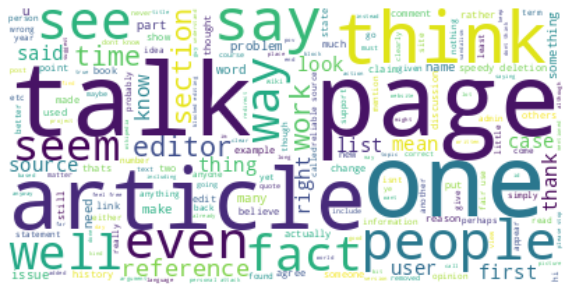

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# text_lt = " ".join(t for t in df["less_toxic"])

text_lt = " ".join(t for t in df_lt['text'])
print ("There are {} words in the combination of all less_toxic reviews.".format(len(text_lt)))

#Generate a word cloud image
wordcloud = WordCloud(stopwords=STOPWORDS,background_color="white").generate(text_lt)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
df_mt=df_train_binary.loc[df_train_binary['y']==1]
df_mt.head()

,text,y
6,cocksucker piss around work,1
12,hey talk exclusive group wp talibanswho good d...,1
16,bye dont look come think comming back tosser,1
42,gay antisemmitian archangel white tiger meow g...,1
43,fuck filthy mother ass dry,1


There are 3176069 words in the combination of all more_toxic reviews.


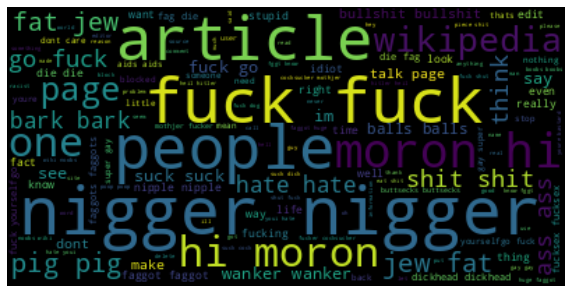

In [17]:
text_mt = " ".join(t for t in df_mt['text'])
print ("There are {} words in the combination of all more_toxic reviews.".format(len(text_mt)))

#Generate a word cloud image
wordcloud = WordCloud(stopwords=STOPWORDS,background_color="black").generate(text_mt)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Unbalanced dataset**

In [18]:
df_train_binary['y'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: y, dtype: float64

In [19]:
toxic_len = (df_train_binary['y'] == 1).sum()
print(toxic_len)

16225


In [20]:
df_train_balanced = df_train_binary[df_train_binary['y'] == 0].sample(n=toxic_len)
df_train_balanced['y'].value_counts(normalize=True)

0    1.0
Name: y, dtype: float64

**Balanced dataset**

In [21]:
df_train_b = pd.concat([df_train_binary[df_train_binary['y'] == 1], df_train_balanced])
df_train_b['y'].value_counts()

1    16225
0    16225
Name: y, dtype: int64

**TF-IDF**

In [22]:
vec = TfidfVectorizer()

In [23]:
X = vec.fit_transform(df_train_b['text'])
X

<32450x72426 sparse matrix of type '<class 'numpy.float64'>'
	with 775815 stored elements in Compressed Sparse Row format>

In [24]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X, df_train_b['y'])

MultinomialNB()

In [25]:
df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
df_val.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


In [26]:
unrelevant_words = ['wiki','wikipedia','page']
#Clean step 1, 2 and 3
df_val['less_toxic'] = df_val['less_toxic'].apply(lambda x: ''.join([w for w in clean_text(x) if w not in unrelevant_words]))

#Clean Step 4
df_val['less_toxic'] = df_val['less_toxic'].apply(lambda x: ''.join([w for w in stopwords(x,stop_words)]))

#Clean Step 5
df_val['less_toxic'] = df_val['less_toxic'].apply(lambda x: ''.join([w for w in lemmatizer.lemmatize(x)]))

df_val.head()

,worker,less_toxic,more_toxic
0,313,article sucks woo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,yes people recognize usually dont one first ob...,Daphne Guinness \n\nTop of the mornin' my fav...
2,82,western media yup every crime entire world cau...,"""Atom you don't believe actual photos of mastu..."
3,347,removed numbskull dont care say anymore life g...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina bluerasberry dont model cheesy b...,"hey \n\nway to support nazis, you racist"


In [27]:
df_val['more_toxic'] = df_val['more_toxic'].apply(lambda x: ''.join([w for w in clean_text(x) if w not in unrelevant_words]))

#Clean Step 4
df_val['more_toxic'] = df_val['more_toxic'].apply(lambda x: ''.join([w for w in stopwords(x,stop_words)]))

#Clean Step 5
df_val['more_toxic'] = df_val['more_toxic'].apply(lambda x: ''.join([w for w in lemmatizer.lemmatize(x)]))

df_val.head()

,worker,less_toxic,more_toxic
0,313,article sucks woo woo wooooooo,wher sexy pic gone main page put back
1,188,yes people recognize usually dont one first ob...,daphne guinness top mornin favourite alien lif...
2,82,western media yup every crime entire world cau...,atom dont believe actual photos masturbation s...
3,347,removed numbskull dont care say anymore life g...,seem sand vagina might want wash stinking hole...
4,539,smelly vagina bluerasberry dont model cheesy b...,hey way support nazis racist


In [28]:
X_less_toxic = vec.transform(df_val['less_toxic'])
X_more_toxic = vec.transform(df_val['more_toxic'])

In [29]:
p1 = model.predict_proba(X_less_toxic)
p2 = model.predict_proba(X_more_toxic)

In [30]:
(p1[:, 1] < p2[:, 1]).mean()

0.665238474823967

In [31]:
# # Create a score that messure how much toxic is a comment
# random_score = {'obscene': 0.20, 'toxic': 0.40, 'threat': 0.6, 
#             'insult': 0.65, 'severe_toxic': 0.9, 'identity_hate': 0.9}

# for category in random_score:
#     df_train[category] = df_train[category] * random_score[category]

# df_train['score'] = df_train.loc[:, 'toxic':'identity_hate'].mean(axis=1)
# df_train['y'] = df_train['score']

# min_len = (df_train['y'] > 0).sum()  # len of toxic comments
# df_non_tox = df_train[df_train['y'] == 0].sample(n=min_len, random_state=201)  # take non toxic comments
# df_train_new = pd.concat([df_train[df_train['y'] > 0], df_non_tox])  # make new df
# df_train_new.head()


In [32]:
# extracting the number of examples of each class
# toxic_len = df_train_new[df_train_new['toxic'] >0].shape[0]
# severe_toxic_len = df_train_new[df_train_new['severe_toxic'] >0].shape[0]
# obscene_len = df_train_new[df_train_new['obscene'] >0].shape[0]
# threat_len = df_train_new[df_train_new['threat'] >0].shape[0]
# insult_len = df_train_new[df_train_new['insult'] >0].shape[0]
# identity_hate_len = df_train_new[df_train_new['identity_hate'] >0].shape[0]
